In [2]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import RZZGate
import numpy as np
from qiskit import transpile
import matplotlib.pyplot as plt
from collections import Counter

In [4]:
n_qubits = 3
chi_t_values = np.linspace(0, 1.0, 11)
thetas = np.linspace(0, 2**np.pi, 42)

In [45]:
def apply_dipole_interaction(circuit, qubits, chi_t):
    n = len(qubits)
    for i in range(n):
        for j in range(i + 1, n):
            qi, qj = qubits[i], qubits[j]

            # ZZ term
            circuit.append(RZZGate(2 * chi_t), [qi, qj])

            # XX term 
            theta_x = -chi_t
            circuit.h(qi); circuit.h(qj)
            circuit.cx(qi, qj)
            circuit.rz(theta_x, qj)
            circuit.cx(qi, qj)
            circuit.h(qi); circuit.h(qj)

            # YY term
            theta_y = -chi_t
            circuit.rx(np.pi/2, qi); circuit.rx(np.pi/2, qj)
            circuit.cx(qi, qj)
            circuit.rz(theta_y, qj)
            circuit.cx(qi, qj)
            circuit.rx(-np.pi/2, qi); circuit.rx(-np.pi/2, qj)
            
    return circuit

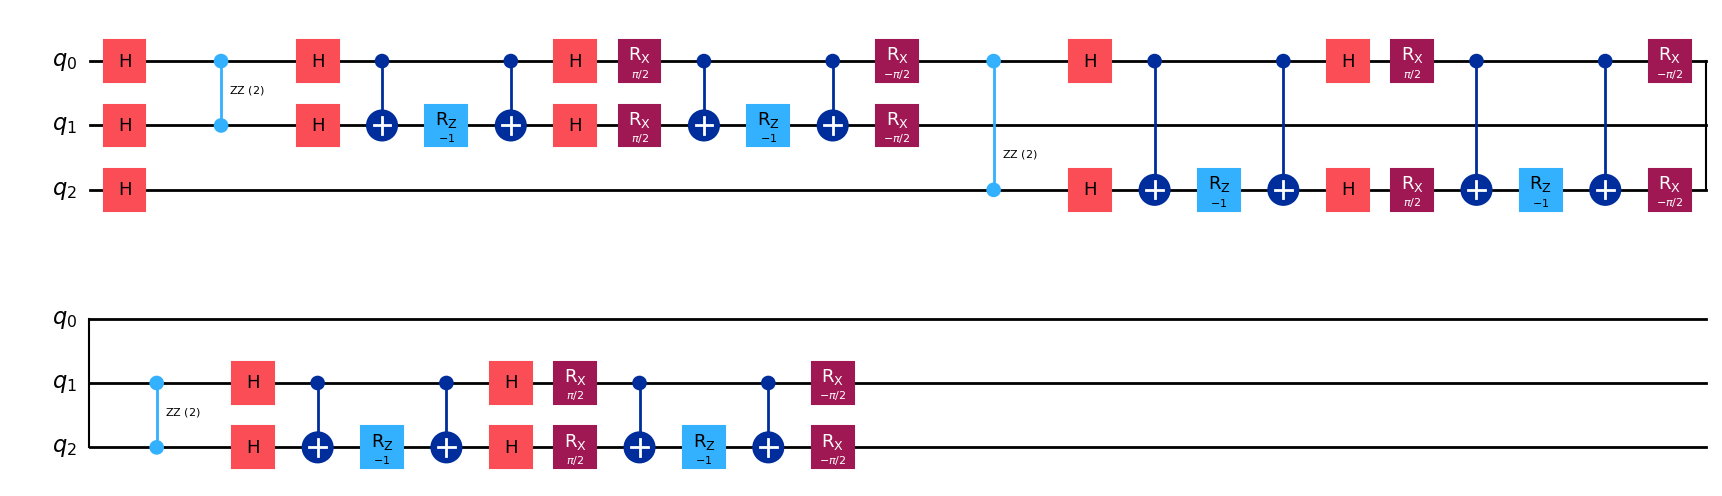

In [47]:
qc = QuantumCircuit(n_qubits)
qc.h(range(n_qubits)) 
apply_dipole_interaction(qc, list(range(n_qubits)), chi_t) 
    
display(qc.draw(output="mpl"))

In [16]:
# For Z-Basis
backend = AerSimulator()

def calculate_jz_and_delta_jz(counts, n_qubits=3):
    expectation = 0
    expectation_sq = 0
    total_shots = sum(counts.values())
    
    for bitstring, count in counts.items():
        n_zeros = bitstring.count('0')  
        n_ones = bitstring.count('1')   
        jz_value = (n_zeros - n_ones) / 2
        prob = count / total_shots
        expectation += prob * jz_value
        expectation_sq += prob * (jz_value ** 2)
    
    delta_jz = (expectation_sq - expectation ** 2) ** 0.5
    return expectation, delta_jz

# Store all results: (theta, chi_t, delta_jz)
all_results_z = []

for theta in thetas:
    for chi_t in chi_t_values:
        qc_z = QuantumCircuit(n_qubits)
        qc_z.h(range(n_qubits))
        apply_dipole_interaction(qc_z, list(range(n_qubits)), chi_t)
        qc_z.measure_all()
        
        job = backend.run(transpile(qc_z, backend), shots=1000)
        counts = job.result().get_counts()
        
        jz, delta_jz = calculate_jz_and_delta_jz(counts, n_qubits=3)
        all_results_z.append((theta, chi_t, delta_jz))

# Find the theta with the smallest min(ΔJz)
theta_min = min(thetas, key=lambda theta: min(delta_jz for t, chi, delta_jz in all_results_z if t == theta))

# Extract all (chi_t, delta_jz) pairs for theta_min
results_for_theta_min = [(chi_t, delta_jz) for t, chi_t, delta_jz in all_results_z if t == theta_min]

print(f"\nOptimal θ = {theta_min:.3f}")
print("χt and ΔJz values for this θ:")
for chi_t, delta_jz in results_for_theta_min:
    print(f"χt = {chi_t:.3f} → ΔJz = {delta_jz:.4f}")


Optimal θ = 1.507
χt and ΔJz values for this θ:
χt = 0.000 → ΔJz = 0.8721
χt = 0.100 → ΔJz = 0.9040
χt = 0.200 → ΔJz = 0.8624
χt = 0.300 → ΔJz = 0.8367
χt = 0.400 → ΔJz = 0.8578
χt = 0.500 → ΔJz = 0.8402
χt = 0.600 → ΔJz = 0.8729
χt = 0.700 → ΔJz = 0.8692
χt = 0.800 → ΔJz = 0.8197
χt = 0.900 → ΔJz = 0.8828
χt = 1.000 → ΔJz = 0.8660


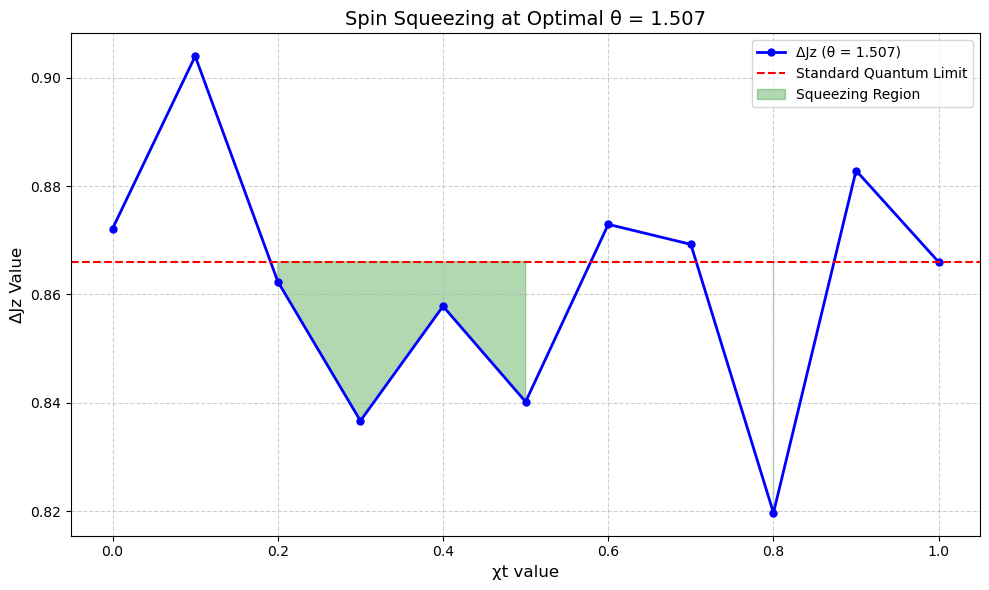

In [26]:
chi_t_vals = [result[0] for result in results_for_theta_min]
delta_jz_vals = [result[1] for result in results_for_theta_min]

plt.figure(figsize=(10, 6))
plt.plot(chi_t_vals, delta_jz_vals, 'b-o', linewidth=2, markersize=5, label=f'ΔJz (θ = {theta_min:.3f})')

sql = np.sqrt(n_qubits / 4)
plt.axhline(y=sql, color='r', linestyle='--', label='Standard Quantum Limit')

plt.fill_between(chi_t_vals, delta_jz_vals, sql, 
                 where=(delta_jz_vals <= sql), 
                 color='green', alpha=0.3, label='Squeezing Region')

plt.xlabel("χt value", fontsize=12)
plt.ylabel("ΔJz Value", fontsize=12)
plt.title(f"Spin Squeezing at Optimal θ = {theta_min:.3f}", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
# For X-Basis
backend = AerSimulator()

def calculate_jx_and_delta_jx(counts, n_qubits=3):
    expectation = 0
    expectation_sq = 0
    total_shots = sum(counts.values())
    
    for bitstring, count in counts.items():
        n_zeros = bitstring.count('0')  
        n_ones = bitstring.count('1')   
        jx_value = (n_zeros - n_ones) / 2
        prob = count / total_shots
        expectation += prob * jx_value
        expectation_sq += prob * (jx_value ** 2)
    
    delta_jx = (expectation_sq - expectation ** 2) ** 0.5
    return expectation, delta_jx

# Store all results: (theta, chi_t, delta_jx)
all_results_x = []

for theta in thetas:
    for chi_t in chi_t_values:
        qc_x = QuantumCircuit(n_qubits)
        qc_x.h(range(n_qubits))
        apply_dipole_interaction(qc_x, list(range(n_qubits)), chi_t)
        qc_x.h(range(n_qubits))
        qc_x.measure_all() 
        
        job = backend.run(transpile(qc_x, backend), shots=1000)
        counts = job.result().get_counts()
        
        jx, delta_jx = calculate_jx_and_delta_jx(counts, n_qubits=3)
        all_results_x.append((theta, chi_t, delta_jx))

# Find the theta with the smallest min(ΔJx)
theta_min = min(thetas, key=lambda theta: min(delta_jx for t, chi, delta_jx in all_results_x if t == theta))

# Extract all (chi_t, delta_jx) pairs for theta_min
results_for_theta_min = [(chi_t, delta_jx) for t, chi_t, delta_jx in all_results_x if t == theta_min]

print(f"\nOptimal θ = {theta_min:.3f}")
print("χt and ΔJx values for this θ:")
for chi_t, delta_jx in results_for_theta_min:
    print(f"χt = {chi_t:.3f} → ΔJx = {delta_jx:.4f}")


Optimal θ = 0.000
χt and ΔJx values for this θ:
χt = 0.000 → ΔJx = 0.0000
χt = 0.100 → ΔJx = 0.4787
χt = 0.200 → ΔJx = 0.8455
χt = 0.300 → ΔJx = 0.9910
χt = 0.400 → ΔJx = 0.9533
χt = 0.500 → ΔJx = 0.8325
χt = 0.600 → ΔJx = 0.6770
χt = 0.700 → ΔJx = 0.6791
χt = 0.800 → ΔJx = 0.6546
χt = 0.900 → ΔJx = 0.7650
χt = 1.000 → ΔJx = 0.8312


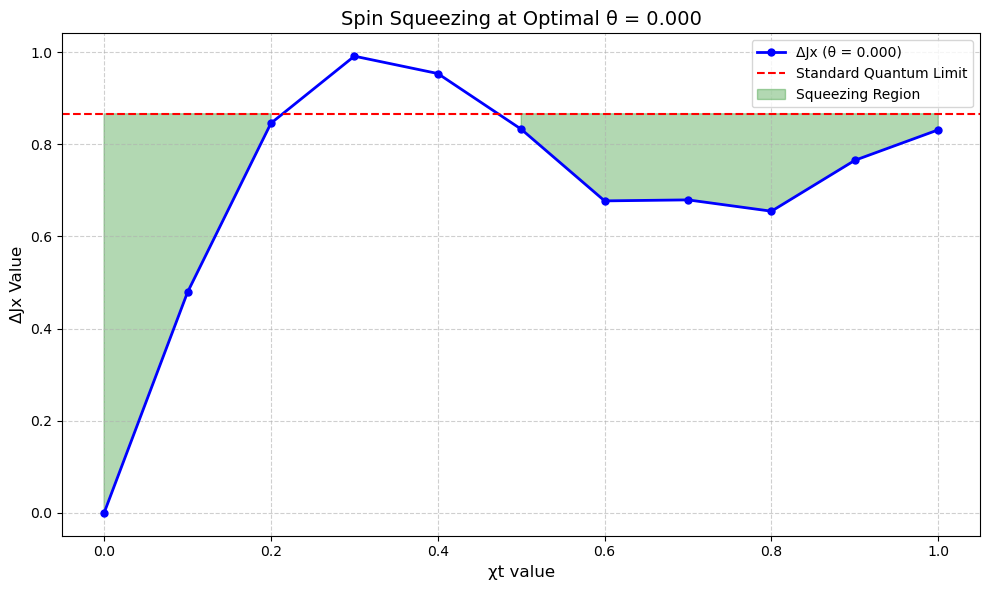

In [32]:
chi_t_vals = [result[0] for result in results_for_theta_min]
delta_jx_vals = [result[1] for result in results_for_theta_min]

plt.figure(figsize=(10, 6))
plt.plot(chi_t_vals, delta_jx_vals, 'b-o', linewidth=2, markersize=5, label=f'ΔJx (θ = {theta_min:.3f})')

sql = np.sqrt(n_qubits / 4)
plt.axhline(y=sql, color='r', linestyle='--', label='Standard Quantum Limit')

plt.fill_between(chi_t_vals, delta_jx_vals, sql, 
                 where=(delta_jx_vals <= sql), 
                 color='green', alpha=0.3, label='Squeezing Region')

plt.xlabel("χt value", fontsize=12)
plt.ylabel("ΔJx Value", fontsize=12)
plt.title(f"Spin Squeezing at Optimal θ = {theta_min:.3f}", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
# For Y-Basis
backend = AerSimulator()

def calculate_jy_and_delta_jy(counts, n_qubits=3):
    expectation = 0
    expectation_sq = 0
    total_shots = sum(counts.values())
    
    for bitstring, count in counts.items():
        n_zeros = bitstring.count('0')  
        n_ones = bitstring.count('1')   
        jy_value = (n_zeros - n_ones) / 2
        prob = count / total_shots
        expectation += prob * jy_value
        expectation_sq += prob * (jy_value ** 2)
    
    delta_jy = (expectation_sq - expectation ** 2) ** 0.5
    return expectation, delta_jy

# Store all results: (theta, chi_t, delta_jy)
all_results_y = []

for theta in thetas:
    for chi_t in chi_t_values:
        qc_y = QuantumCircuit(n_qubits)
        qc_y.h(range(n_qubits))
        apply_dipole_interaction(qc_y, list(range(n_qubits)), chi_t)
        qc_y.sdg(range(n_qubits))
        qc_y.h(range(n_qubits))
        qc_y.measure_all()
            
        job = backend.run(transpile(qc_y, backend), shots=1000)
        counts = job.result().get_counts()
        
        jy, delta_jy = calculate_jy_and_delta_jy(counts, n_qubits=3)
        all_results_y.append((theta, chi_t, delta_jy))

# Find the theta with the smallest min(ΔJy)
theta_min = min(thetas, key=lambda theta: min(delta_jy for t, chi, delta_jy in all_results_y if t == theta))

# Extract all (chi_t, delta_jy) pairs for theta_min
results_for_theta_min = [(chi_t, delta_jy) for t, chi_t, delta_jy in all_results_y if t == theta_min]

print(f"\nOptimal θ = {theta_min:.3f}")
print("χt and ΔJy values for this θ:")
for chi_t, delta_jy in results_for_theta_min:
    print(f"χt = {chi_t:.3f} → ΔJy = {delta_jy:.4f}")


Optimal θ = 6.673
χt and ΔJy values for this θ:
χt = 0.000 → ΔJy = 0.8355
χt = 0.100 → ΔJy = 0.9267
χt = 0.200 → ΔJy = 1.1054
χt = 0.300 → ΔJy = 1.2504
χt = 0.400 → ΔJy = 1.3656
χt = 0.500 → ΔJy = 1.3812
χt = 0.600 → ΔJy = 1.3270
χt = 0.700 → ΔJy = 1.2530
χt = 0.800 → ΔJy = 1.1826
χt = 0.900 → ΔJy = 1.0363
χt = 1.000 → ΔJy = 0.9241


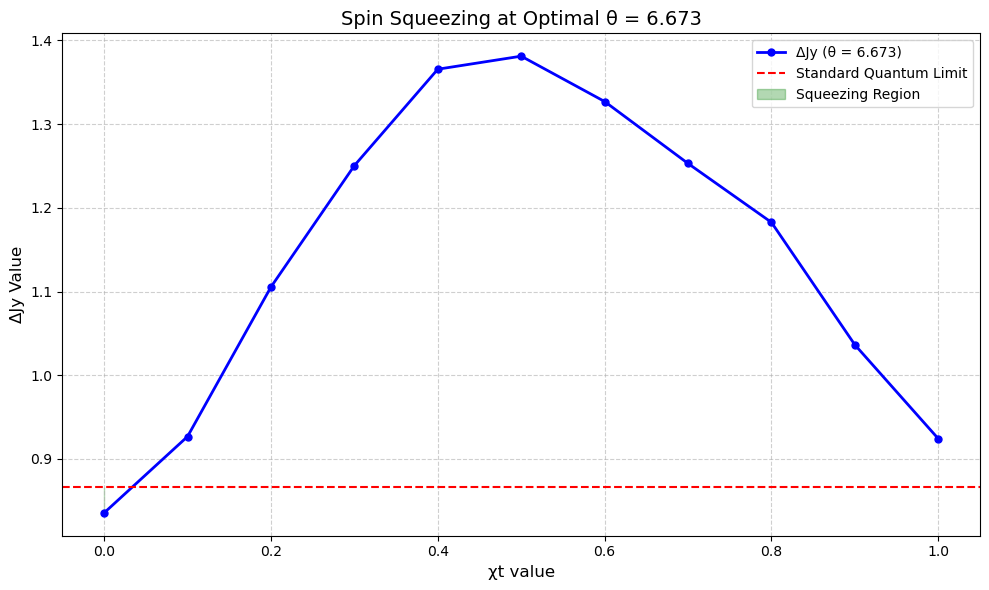

In [37]:
chi_t_vals = [result[0] for result in results_for_theta_min]
delta_jy_vals = [result[1] for result in results_for_theta_min]

plt.figure(figsize=(10, 6))
plt.plot(chi_t_vals, delta_jy_vals, 'b-o', linewidth=2, markersize=5, label=f'ΔJy (θ = {theta_min:.3f})')

sql = np.sqrt(n_qubits / 4)
plt.axhline(y=sql, color='r', linestyle='--', label='Standard Quantum Limit')

plt.fill_between(chi_t_vals, delta_jy_vals, sql, 
                 where=(delta_jy_vals <= sql), 
                 color='green', alpha=0.3, label='Squeezing Region')

plt.xlabel("χt value", fontsize=12)
plt.ylabel("ΔJy Value", fontsize=12)
plt.title(f"Spin Squeezing at Optimal θ = {theta_min:.3f}", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()

In [78]:
# Plotting to Show Heisenberg Uncertainty Principle

# For Z-Basis at theta_y_min

# Store all results: (theta, chi_t, delta_jz)
all_results_z2 = []

for theta in thetas:
    for chi_t in chi_t_values:
        qc_z2 = QuantumCircuit(n_qubits)
        qc_z2.h(range(n_qubits))
        apply_dipole_interaction(qc_z2, list(range(n_qubits)), chi_t)
        qc_z2.measure_all()
        
        job = backend.run(transpile(qc_z2, backend), shots=1000)
        counts = job.result().get_counts()
        
        jz2, delta_jz2 = calculate_jz_and_delta_jz(counts, n_qubits=3)
        all_results_z2.append((theta, chi_t, delta_jz2))

# Find the theta with the smallest min(ΔJz)
theta_min = theta_min_y

# Extract all (chi_t, delta_jz) pairs for theta_min
results_for_theta_min_z2 = [(chi_t, delta_jz2) for t, chi_t, delta_jz2 in all_results_z2 if t == theta_min]

print(f"\nOptimal θ = {theta_min:.3f}")
print("χt and ΔJz values for this θ:")
for chi_t, delta_jz2 in results_for_theta_min_z2:
    print(f"χt = {chi_t:.3f} → ΔJz = {delta_jz2:.4f}")


Optimal θ = 6.673
χt and ΔJz values for this θ:
χt = 0.000 → ΔJz = 0.8792
χt = 0.100 → ΔJz = 0.8883
χt = 0.200 → ΔJz = 0.8931
χt = 0.300 → ΔJz = 0.8521
χt = 0.400 → ΔJz = 0.8567
χt = 0.500 → ΔJz = 0.8629
χt = 0.600 → ΔJz = 0.8556
χt = 0.700 → ΔJz = 0.8602
χt = 0.800 → ΔJz = 0.8620
χt = 0.900 → ΔJz = 0.8579
χt = 1.000 → ΔJz = 0.8472


In [79]:
# For X-Basis at theta_y_min

# Store all results: (theta, chi_t, delta_jx)
all_results_x2 = []

for theta in thetas:
    for chi_t in chi_t_values:
        qc_x2 = QuantumCircuit(n_qubits)
        qc_x2.h(range(n_qubits))
        apply_dipole_interaction(qc_x2, list(range(n_qubits)), chi_t)
        qc_x2.h(range(n_qubits))
        qc_x2.measure_all() 
        
        job = backend.run(transpile(qc_x2, backend), shots=1000)
        counts = job.result().get_counts()
        
        jx2, delta_jx2 = calculate_jx_and_delta_jx(counts, n_qubits=3)
        all_results_x2.append((theta, chi_t, delta_jx2))

# Find the theta with the smallest min(ΔJx)
theta_min2 = theta_min_y

# Extract all (chi_t, delta_jx) pairs for theta_min
results_for_theta_min_x2 = [(chi_t, delta_jx2) for t, chi_t, delta_jx2 in all_results_x2 if t == theta_min2]

print(f"\nOptimal θ = {theta_min:.3f}")
print("χt and ΔJx values for this θ:")
for chi_t, delta_jx2 in results_for_theta_min_x2:
    print(f"χt = {chi_t:.3f} → ΔJx = {delta_jx2:.4f}")


Optimal θ = 6.673
χt and ΔJx values for this θ:
χt = 0.000 → ΔJx = 0.0000
χt = 0.100 → ΔJx = 0.4190
χt = 0.200 → ΔJx = 0.8216
χt = 0.300 → ΔJx = 0.9956
χt = 0.400 → ΔJx = 0.9322
χt = 0.500 → ΔJx = 0.7814
χt = 0.600 → ΔJx = 0.6856
χt = 0.700 → ΔJx = 0.6182
χt = 0.800 → ΔJx = 0.6856
χt = 0.900 → ΔJx = 0.7650
χt = 1.000 → ΔJx = 0.8174


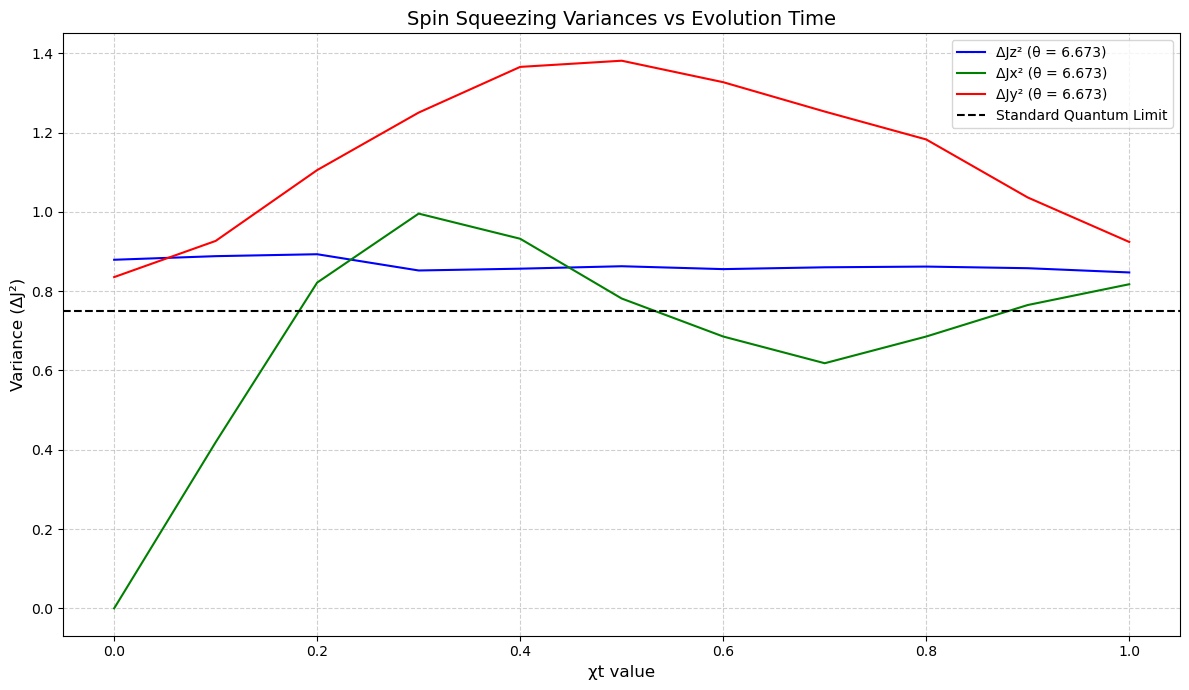

In [86]:
# Create a combined plot
plt.figure(figsize=(12, 7))

theta_min_y = min(thetas, key=lambda theta: min(delta_jy for t, chi, delta_jy in all_results_y if t == theta))

results_z2 = [(chi_t, delta_jz2) for t, chi_t, delta_jz2 in all_results_z2 if t == theta_min_y]
results_x2 = [(chi_t, delta_jx2) for t, chi_t, delta_jx2 in all_results_x2 if t == theta_min_y]
results_y = [(chi_t, delta_jy) for t, chi_t, delta_jy in all_results_y if t == theta_min_y]

plt.plot([r[0] for r in results_z2], [r[1] for r in results_z2], 'b-', label=f'ΔJz² (θ = {theta_min_y:.3f})')
plt.plot([r[0] for r in results_x2], [r[1] for r in results_x2], 'g-', label=f'ΔJx² (θ = {theta_min_y:.3f})')
plt.plot([r[0] for r in results_y], [r[1] for r in results_y], 'r-', label=f'ΔJy² (θ = {theta_min_y:.3f})')

sql = n_qubits / 4  # SQL variance
plt.axhline(y=sql, color='k', linestyle='--', label='Standard Quantum Limit')

plt.xlabel("χt value", fontsize=12)
plt.ylabel("Variance (ΔJ²)", fontsize=12)
plt.title("Spin Squeezing Variances vs Evolution Time", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()